# Data Quality

This notebook shows some of the data quality functions associated with spectra, based on on 
the standard OnOff observation we have seen before.


You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/quality.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/quality.ipynb" download>here</a> and selecting "Save Link As".

The following Spectrum functions will be discussed

```
stats         - statistics of a spectrum
roll          - a series of rolls (1,2,3...) to discover channel correlations and/or ripples in the spectrum
radiometer    - adherence of spectrum to the radiometer equation
snr           - signal/noise ratio, either channel or flux based
sratio        - flux ratio, an indiction of a number between -1 and 1
normalness    - likelyhood noise is a gaussian
```

## Loading Modules

We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

import numpy as np

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
from dysh.util.files import dysh_data
from dysh.spectra.spectrum import Spectrum

## Data Loading

We use the standard **getps** (AGBT05B_047_01) test
and use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [2]:
filename = dysh_data(test="getps")      # AGBT05B_047_01/AGBT05B_047_01.raw.acs
sdfits = GBTFITSLoad(filename)

In [3]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

First we extract a (time-averaged) spectrum from the first scan. If you recall from the Position-Switch observation, both edges have some problems, and for the purpose of this we remove the first 5000 and last 2768 channels. We plot this spectrum and perform statistics on the first 10000 channels, which look line free

**NOTE**:  the way we make the channel selection for sp1 is a lazy one (feature/bug) and results in a BW=50MHz printed in the plot below, but this is incorrect.

{'mean': <Quantity 0.26528672 K>,
 'median': <Quantity 0.26475095 K>,
 'rms': <Quantity 0.07121472 K>,
 'min': <Quantity 0.00017927 K>,
 'max': <Quantity 0.55562308 K>,
 'npt': 10000,
 'nan': 0}

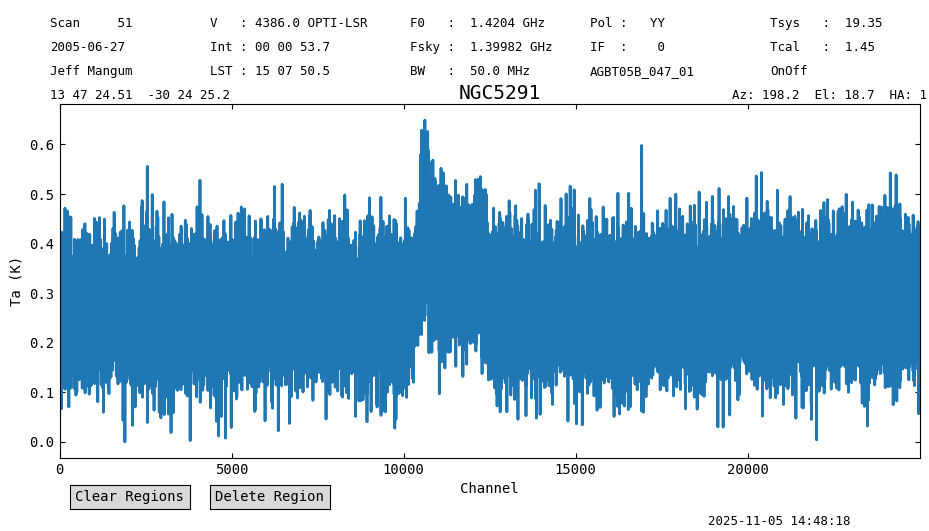

In [4]:
sp1 = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
sp1.plot(xaxis_unit='chan')
sp1[:10000].stats()

There is a significant continuum left, plus the two sections on either side of the line clearly have
a diffent continuum level (0.265 vs. 0.281).

The same holds for the RMS, though this appears to be related to a large slope in the last section of the spectrum.


In [5]:
sp1[:-10000].stats()

{'mean': <Quantity 0.28060025 K>,
 'median': <Quantity 0.27762201 K>,
 'rms': <Quantity 0.0786351 K>,
 'min': <Quantity 0.00017927 K>,
 'max': <Quantity 0.64907953 K>,
 'npt': 15000,
 'nan': 0}

In [6]:
#  using roll=1 (and assuming non-correlated channels) we get a better estimate for the RMS and
#  confirm the values are more consistent with each other
print(sp1[:10000].stats(roll=1)["rms"]/np.sqrt(2))
print(sp1[:-10000].stats(roll=1)["rms"]/np.sqrt(2))

0.0702642971816383 K
0.0707339744193836 K


## Roll

Rolling the data can tell us if there is channel-to-channel correlations, but they are also affected by
slow variations as is the case with this spectrum.  

We thus compare the first and second half


In [7]:
sp1[:10000].roll(4)

[1.0135264176511074,
 0.9988245936948404,
 1.0009603161121046,
 1.0088321962353017]

In [8]:
sp1[:-10000].roll(4)

[1.1117019681704385,
 1.1033338769611336,
 1.0999308929835787,
 1.1118575789046694]

##  Radiometer Equation

For a given $T_{sys}$, channel width $\Delta f$ and observing time $\Delta t$ the radiometer equation predicts the expected noise as:
$$
  \Delta T = {  { T_{sys} } \over \sqrt{ \Delta f \Delta t } }
$$
The `radiometer()` function will return the ratio of the measured noise to this expected noise

In [9]:
sp1.radiometer()

1.125255087134089

In [10]:
sp1[:10000].radiometer()

1.0534482472856415

In [11]:
print(sp1[:-10000].radiometer())
print(sp1[:-10000].radiometer(roll=1))


1.1632146434203927
1.0463367671595745


Notice again that due to the articial high RMS because of the baseline, the first call to `radiometer()` resulted in a too high value of 1.16, whereas with `roll=1` it found 1.05

## Baseline Subtraction

To avoid all this confusion of a continuum, and we have seen this before, as baseline subtraction should
be done. For this, lets define the line to be between channels 10000 and 13000.

'0.007425545812760042 0.07572969277324755 -0.2850430178502208 0.3779922285648112'

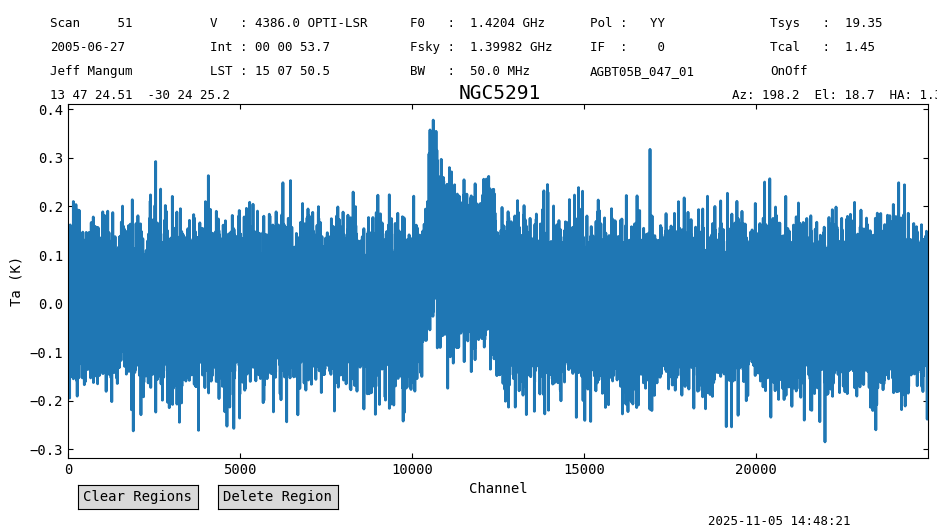

In [12]:
sp1.baseline(2,exclude=[10000,13000], remove=True)
sp1.plot(xaxis_unit='chan')
sp1.stats(qac=True)

In [13]:
# redo those tests, print nicely
print(sp1[:10000].stats())
print(sp1[:10000].stats(roll=1))


print(sp1[:-10000].stats())
print(sp1[:-10000].stats(roll=1))


{'mean': <Quantity -2.2629703e-05 K>, 'median': <Quantity -0.00075626 K>, 'rms': <Quantity 0.07116938 K>, 'min': <Quantity -0.26237535 K>, 'max': <Quantity 0.29259241 K>, 'npt': 10000, 'nan': 0}
{'mean': <Quantity -1.9197046e-06 K>, 'median': <Quantity -0.00102835 K>, 'rms': <Quantity 0.09936872 K>, 'min': <Quantity -0.37160137 K>, 'max': <Quantity 0.35925086 K>, 'npt': 9998, 'nan': 0}
{'mean': <Quantity 0.01252647 K>, 'median': <Quantity 0.00966363 K>, 'rms': <Quantity 0.07786735 K>, 'min': <Quantity -0.26237535 K>, 'max': <Quantity 0.37799223 K>, 'npt': 15000, 'nan': 0}
{'mean': <Quantity 2.37500576e-06 K>, 'median': <Quantity -0.00095611 K>, 'rms': <Quantity 0.10003295 K>, 'min': <Quantity -0.39003708 K>, 'max': <Quantity 0.35925086 K>, 'npt': 14998, 'nan': 0}


In [14]:
sp1[:-10000].roll(4)

[1.1008479554449626, 1.0925615652093792, 1.0891918059831072, 1.101002045942027]

Curious how the radiometer equation holds as function of time?

In [15]:
for s in [51,53,55,57]:
    sp2 = sdfits.getps(scan=s, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
    print(s, sp2[:10000].radiometer())

51 1.0534482472856415
53 1.0403504063163798
55 1.058371483573899
57 1.0434733004644334


## snr:   Signal to Noise ratio

This can be done in two ways:  channel based and flux based. For the latter a section of spectrum where the signal is expected has to be selected

For pure noise in a channel based comparision (the default) we would expect the `snr` to be around 4, higher for higher number of channels, as can be computed via the error function.


In [16]:
sp1[:10000].snr()

4.164491122535507

In [17]:
sp1[:-10000].snr()

5.166764044830665

In [18]:
sp1[10000:13000].snr()


4.445639310616525

## sratio:  Signal Ratio

The signal ratio is defined as the difference between the positive and negative sum of the signals, normalized by the sum of both. This results in a dimensionless number between -1 and 1, where -1 means a pure absorption signal, 0 pure noise, and 1 pure emission line:
$$
     S_r = {{ P_{sum}+ N_{sum} } \over {P_{sum} - N_{sum}}}
$$
note that $N_{sum}$ is negative.

In [19]:
sp1[:10000].sratio()

-0.00039926888385282615

In [20]:
sp1[:-10000].sratio()

0.2018852651376551

In [21]:
sp1[10000:13000].sratio()

0.7404518588445785

## Normalness

A function (to be written) that gives a (chi2?) likelyhood the noise is distribution like a gaussian.

## Smoothing

Smoothing should give us a much clearer detection. Lets see how the previous measures live of to this task.

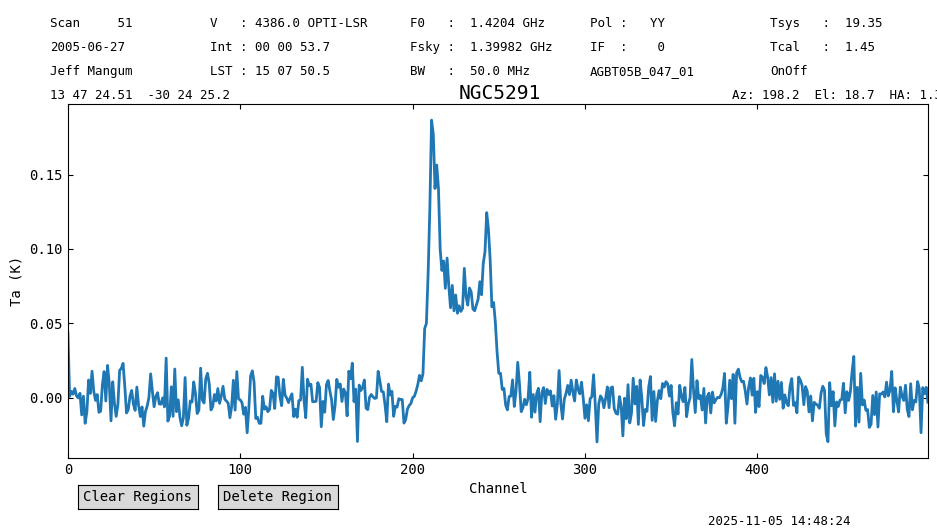

In [22]:
n=50
sp1s = sp1.smooth('hanning',n) 
sp1s.plot(xaxis_unit='chan')

In [23]:
print(sp1s.radiometer())
print(sp1s[:190].radiometer())
print(sp1s[300:].radiometer())
print(sp1s.radiometer(roll=1))

2.870664676246327
1.1365939908967662
1.1035074707704635
1.088936927198691


It seems even with roll=1 (where the best RMS is obtained) the ratio is a bit far from ideal.
Tests with a fake_spectrum() are being done to confirm this.   Not even an issue yet.